In [6]:
# !pip install lmfit

In [7]:
%matplotlib widget

In [8]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt

import lmfit

from scipy import ndimage


In [9]:
files = glob.glob("*.xy")

In [10]:
files

['(Al,Ga)2O3_theta-2theta_scan_2.xy',
 '(Al,Ga)2O3_theta-2theta_scan_8.xy',
 '(Al,Ga)2O3_theta-2theta_scan_6.xy',
 '(Al,Ga)2O3_theta-2theta_scan_7.xy',
 '(Al,Ga)2O3_theta-2theta_scan_1.xy',
 '(Al,Ga)2O3_theta-2theta_scan_0.xy',
 '(Al,Ga)2O3_theta-2theta_scan_9.xy',
 '(Al,Ga)2O3_theta-2theta_scan_5.xy',
 '(Al,Ga)2O3_theta-2theta_scan_10.xy',
 '(Al,Ga)2O3_theta-2theta_scan_3.xy',
 '(Al,Ga)2O3_theta-2theta_scan_4.xy']

In [11]:
files[0]

'(Al,Ga)2O3_theta-2theta_scan_2.xy'

In [12]:
files[1]

'(Al,Ga)2O3_theta-2theta_scan_8.xy'

# load ascii data and skip first row that contains header info

In [13]:
arr = np.loadtxt(files[0], skiprows=1)

In [14]:
arr

array([[2.00106690e+01, 5.02282846e-01],
       [2.00213381e+01, 8.18174611e-01],
       [2.00320071e+01, 9.37078234e-01],
       ...,
       [6.79786619e+01, 2.21593081e-03],
       [6.79893310e+01, 6.69153123e-05],
       [6.80000000e+01, 0.00000000e+00]])

In [15]:
arr.shape

(4499, 2)

In [16]:
arr.dtype

dtype('float64')

In [17]:
arr.sum()

60728750.62222955

In [18]:
arr[0]

array([20.01066904,  0.50228285])

In [19]:
arr[0,0]

20.010669037563904

rename columns for convenience

In [20]:
twotheta = arr[:,0]
intensity = arr[:,1]

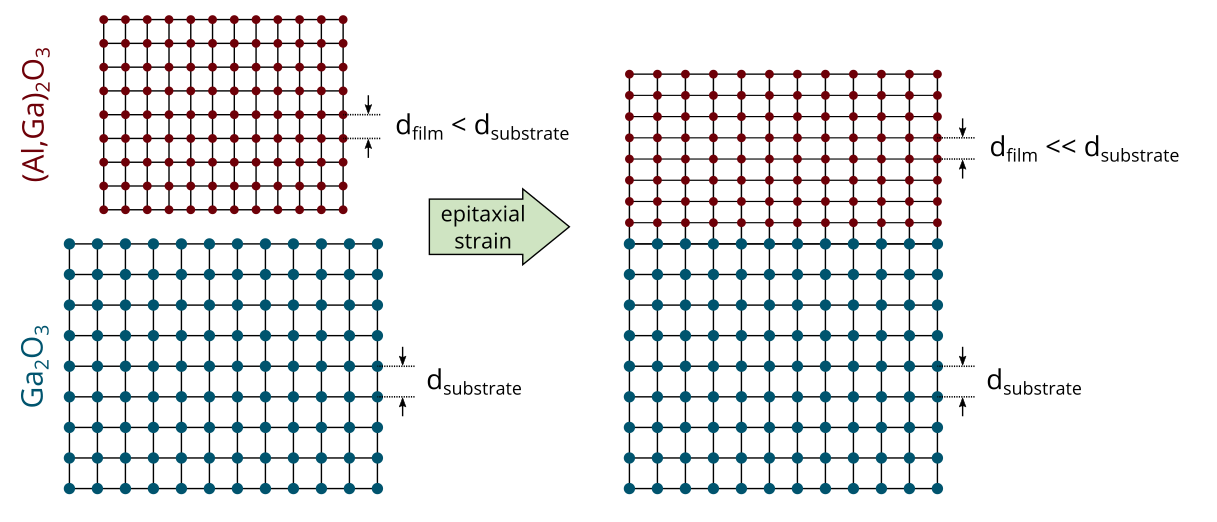


Bragg's law: $n\lambda = 2 d \sin\theta$

plot on logarithmic scale

(44.0, 47.0)

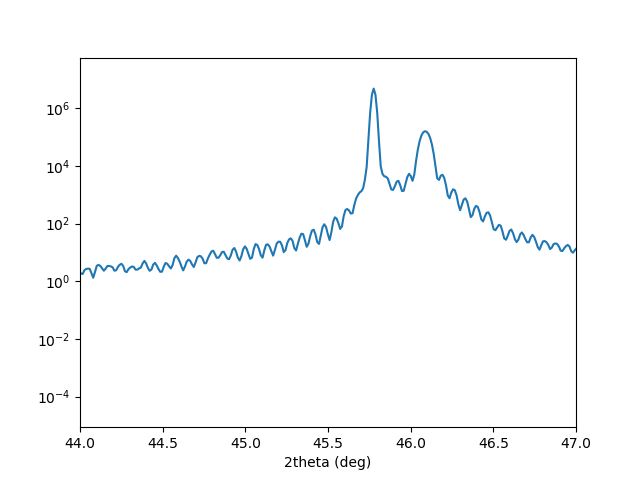

In [21]:
plt.figure()
plt.plot(twotheta, intensity)
plt.yscale("log")
plt.xlabel("2theta (deg)")
plt.xlim(44, 47)

**find the peak maximum position**

4768205.890344816 45.77639475438987


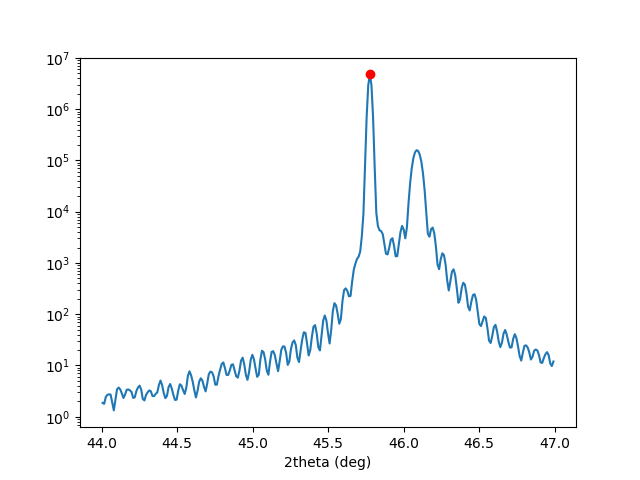

In [22]:



# mask out a region of interest
mask = (twotheta > 44) * (twotheta < 47)
tth_region = twotheta[mask]
I_region = intensity[mask]

plt.figure()
plt.plot(tth_region, I_region)
plt.yscale("log")
plt.xlabel("2theta (deg)")


imax = I_region.argmax()
print(I_region[imax], tth_region[imax])
plt.plot(tth_region[imax],I_region[imax],  "or")

In [111]:
def lorentzian(x, x0, amp, w):
    return amp/(1 + ((x-x0)/w)**2) / (np.pi * w)

def gaussian(x, x0, amp, w, y0=0):
    return amp*np.exp(-(x-x0)**2/(2*w**2))+y0

def standard_normal(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

def pvoigt(x, x0, amp, w, y0=0, eta=0.5):
    # a linear mix of lorentzian and gaussian
    return y0 + amp *    (eta  / (1+((x-x0)/w)**2) \
                     + (1-eta) * np.exp(-np.log(2)*((x-x0)/w)**2))

def sinc(x, x0, amp, w):
    zeta = (x-x0)/w + 1e-2j
    return amp*abs(np.sin(zeta)/zeta)**2


4768205.890344816 45.77639475438987


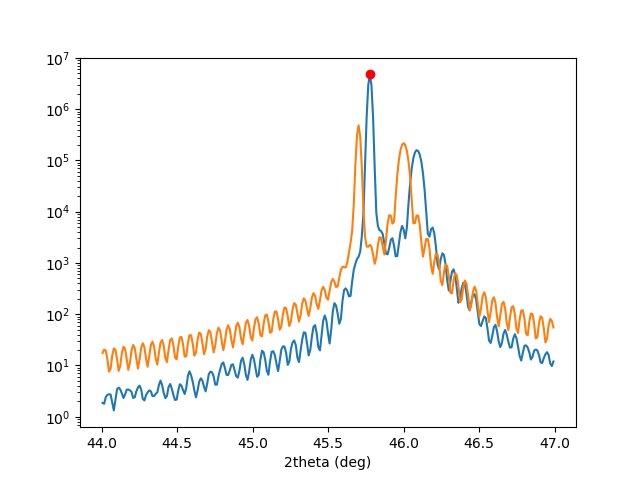

In [112]:



plt.figure()
plt.plot(tth_region, I_region)
plt.yscale("log")
plt.xlabel("2theta (deg)")

imax = I_region.argmax()
tth_max, I_max = tth_region[imax], I_region[imax]

print(I_region[imax], tth_region[imax])
plt.plot(tth_max, I_max,  "or")

sim  = pvoigt(tth_region, 45.7, I_max, 0.001, eta=0.9)
sim += sinc(tth_region, 46, I_max/20, 0.02)

sim = ndimage.gaussian_filter1d(sim, 1)
# sim = ndimage.(sim, 1)

plt.plot(tth_region, sim)

In [121]:
params = lmfit.Parameters()

params.add("cen_sub", value=45.864, vary=False)

params.add("amp_sub", value=I_max/100, min=0)
params.add("w_sub", value=0.003, min=0, max=0.1)

params.add("film_offset", min=0, max=4, value=0.5)
params.add("cen_film", value=tth_max+0.15, expr="cen_sub + film_offset")

params.add("factor_film", min=1, max=1000, value=20)
params.add("amp_film", expr="amp_sub * 1/factor_film")
params.add("w_film", value=0.02, min=0.001, max=0.1)


params.add("tth_offset", min=-0.5, max=0.5)
params.add("broadening", value=1, min=0, max=5)


params["tth_offset"].value = tth_max - params["cen_sub"].value

params

name,value,initial value,min,max,vary,expression
cen_sub,45.8640000,45.864,-inf,inf,False,
amp_sub,47682.0589,47682.05890344816,0.00000000,inf,True,
w_sub,0.00300000,0.003,0.00000000,0.10000000,True,
film_offset,0.50000000,0.5,0.00000000,4.00000000,True,
cen_film,46.3640000,45.92639475438987,-inf,inf,False,cen_sub + film_offset
factor_film,20.0000000,20,1.00000000,1000.00000,True,
amp_film,2384.10295,None,-inf,inf,False,amp_sub * 1/factor_film
w_film,0.02000000,0.02,1.0000e-03,0.10000000,True,
tth_offset,-0.08760525,None,-0.50000000,0.50000000,True,
broadening,1.00000000,1,0.00000000,5.00000000,True,


In [122]:
params.valuesdict()

{'cen_sub': 45.864,
 'amp_sub': 47682.05890344816,
 'w_sub': 0.003,
 'film_offset': 0.5,
 'cen_film': 46.364,
 'factor_film': 20,
 'amp_film': 2384.102945172408,
 'w_film': 0.02,
 'tth_offset': -0.08760524561012772,
 'broadening': 1}

In [123]:
def mymodel(par, x_exp):
    parval = par.valuesdict()
    
    tth_offset = parval["tth_offset"]
    sim  = lorentzian(tth_region-tth_offset, parval["cen_sub"],  parval["amp_sub"],  parval["w_sub"])
    sim += sinc(tth_region-tth_offset,  parval["cen_film"],  parval["amp_film"],  parval["w_film"])
    
    sim = ndimage.gaussian_filter1d(sim, parval["broadening"])
    
    return sim


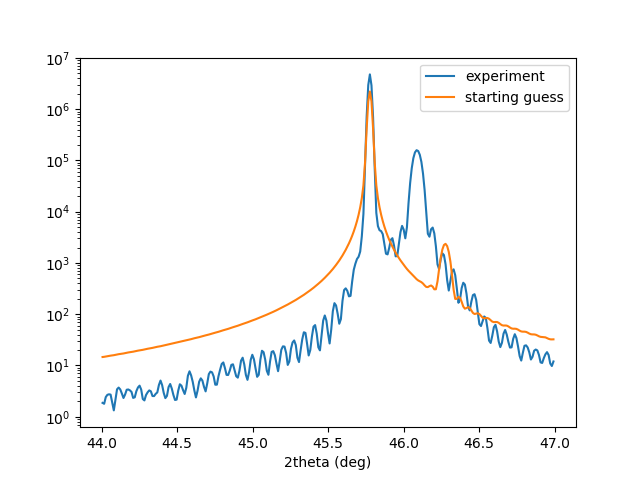

In [124]:



plt.figure()
plt.plot(tth_region, I_region, label="experiment")
plt.yscale("log")
plt.xlabel("2theta (deg)")

I_guess  = mymodel(params, tth_region)

plt.plot(tth_region, I_guess, label="starting guess")

plt.legend()

**Chi-square:**
$$ \chi^2 = \sum_i \frac{(O_i - E_i)^2}{\sigma_i^2} $$


$O_i\dots$ obervations / measurements

$E_i\dots$ expectations / calculations

$\sigma_i\dots$ estimated errors

**Reduced Chi-square**
$$ \chi^2_r = \frac {\chi^2} {n - m}$$

$n\dots$ number of observations

$m\dots$ number of fit parameters



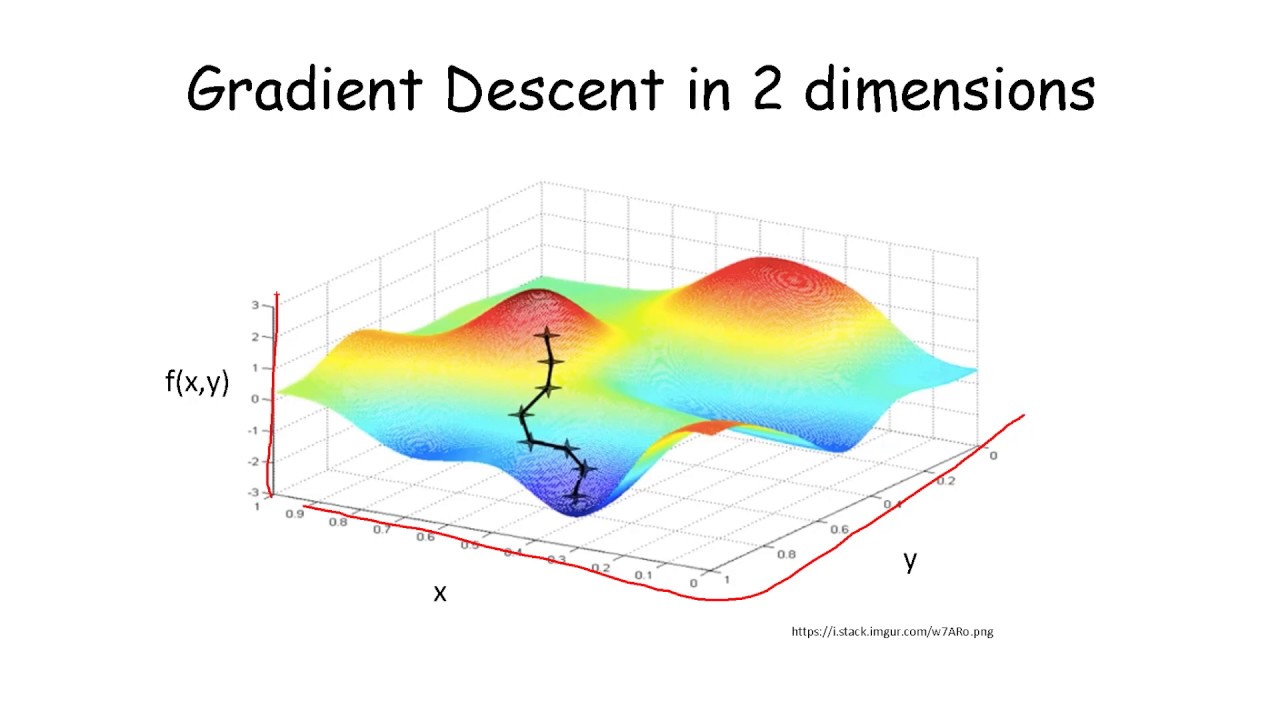

### define a cost function ($\chi^2$?)

In [125]:
def costfunction(par, x_exp, I_exp):
    I_calc = mymodel(par, x_exp)
    
    sigma = np.sqrt(I_exp)
    
    diff = (I_exp - I_calc)/sigma
    
    return diff

    
    

perform minimization

In [126]:
fit = lmfit.minimize(costfunction, params, method="leastsq", args=(tth_region, I_region))
# fit = lmfit.minimize(costfunction, params, method="simplex", args=(tth_region, I_region))

In [127]:
fit.params

name,value,standard error,relative error,initial value,min,max,vary,expression
cen_sub,45.8640000,0.00000000,(0.00%),45.864,-inf,inf,False,
amp_sub,43818581.3,4.9623e+14,(1132472510.80%),47682.05890344816,0.00000000,inf,True,
w_sub,3.1777e-07,3.61652807,(1138084472.28%),0.003,0.00000000,0.10000000,True,
film_offset,0.31293236,0.00195719,(0.63%),0.5,0.00000000,4.00000000,True,
cen_film,46.1769324,0.00195719,(0.00%),46.364,-inf,inf,False,cen_sub + film_offset
factor_film,270.974977,3.0734e+09,(1134184304.98%),20,1.00000000,1000.00000,True,
amp_film,161707.113,2.7681e+09,(1711801.03%),2384.102945172408,-inf,inf,False,amp_sub * 1/factor_film
w_film,0.02219986,4.2648e-05,(0.19%),0.02,1.0000e-03,0.10000000,True,
tth_offset,-0.08821137,0.00192654,(2.18%),-0.08760524561012772,-0.50000000,0.50000000,True,
broadening,1.02025732,0.00319691,(0.31%),1,0.00000000,5.00000000,True,


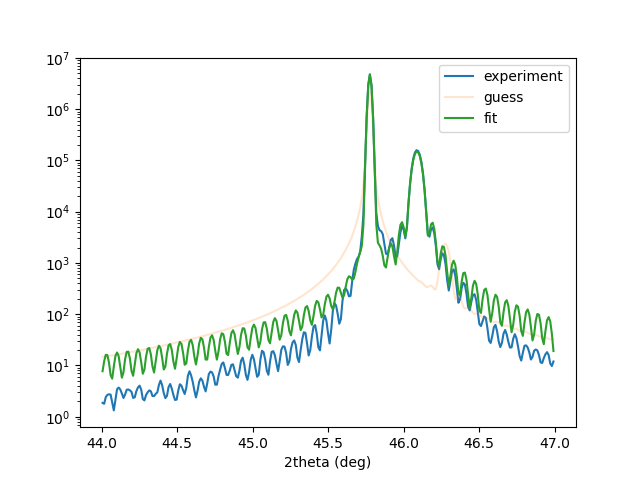

In [128]:

plt.figure()
plt.plot(tth_region, I_region, label="experiment")
plt.yscale("log")
plt.xlabel("2theta (deg)")

I_guess  = mymodel(params, tth_region)
I_fit    = mymodel(fit.params, tth_region)

plt.plot(tth_region, I_guess, label="guess", alpha=0.2)
plt.plot(tth_region, I_fit, label="fit")
plt.legend()

# load calibration curve relating peak position to Al-content in $Al_{2x}Ga_{2(1-x)}O_{3}$

also make a polynomial (2nd order) fit allowing us to interpolate the calibration curve

In [129]:
x, tth_600 = np.loadtxt("tth_vs_x_strained.dat", skiprows=1, unpack=True)

Text(0, 0.5, '2theta of 600 reflection (deg)')

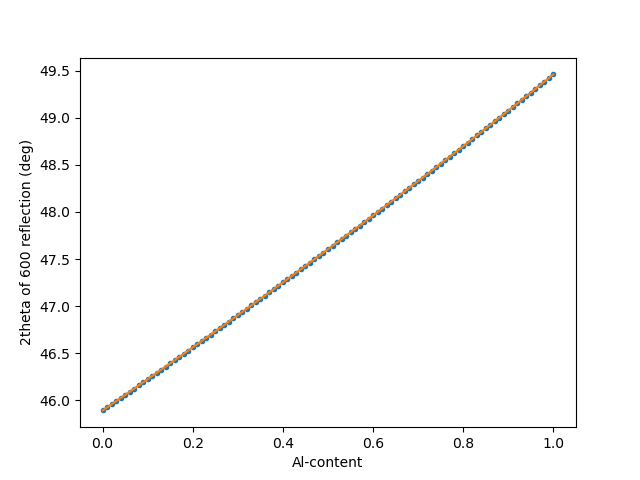

In [130]:
plt.figure()
plt.plot(x, tth_600, ".")

poly = np.polyfit(tth_600, x, 2)
x_vs_tth = np.poly1d(poly)


plt.plot(x_vs_tth(tth_600), tth_600, "-")
plt.xlabel("Al-content")
plt.ylabel("2theta of 600 reflection (deg)")


# now do everything again in a loop over all the scan files

In [ ]:
plt.figure(figsize=(8,4))


results = []

for path in files:
    arr = np.loadtxt(path, skiprows=1)
    twotheta = arr[:,0]
    intensity = arr[:,1]

    mask = (twotheta > 44) * (twotheta < 47)
    tth_region = twotheta[mask]
    I_region = intensity[mask]
    imax = I_region.argmax()
    tth_max, I_max = tth_region[imax], I_region[imax]


    params["tth_offset"].value = tth_max - params["cen_sub"].value

    fit = lmfit.minimize(costfunction, params, method="leastsq", args=(tth_region, I_region))
    # fit = lmfit.minimize(costfunction, params, method="simplex", args=(tth_region, I_region)) # sometimes more robust, but slower
    
    cen_subs = fit.params["cen_sub"].value
    cen_film = fit.params["cen_film"].value
    tth_offset = fit.params["tth_offset"].value
    
    I_fit = mymodel(fit.params, tth_region)
    line = plt.plot(twotheta-tth_offset, intensity, ".", markersize=1)[0]
    maincolor = line.get_color()

    plt.plot(tth_region-tth_offset, I_fit, "-", color=maincolor)
    
    
    Al_content = x_vs_tth(cen_film)

    
    mylabel = "%s - Al-content: %.2f%%"%(path.split("2theta_")[1], Al_content*100)
    line.set_label(mylabel)
    
    results.append((path, cen_film, Al_content))

    print(path, cen_film, Al_content, fit.redchi)

    # plt.plot(tth_film, w,  "-")
    plt.plot([cen_subs, cen_subs], [I_region.min(), I_region.max()],  "--", color=maincolor)
    plt.plot([cen_film, cen_film], [I_region.min(), I_region.max()],  "--", color=maincolor)
    # plt.plot([cen, cen], [I_film.min(), I_film.pmax()],  "--r")
    # break

plt.legend()
plt.yscale("log")
plt.xlim(45, 48)
plt.savefig("peakpos.pdf")

(Al,Ga)2O3_theta-2theta_scan_2.xy 46.17693235591767 0.0853037588501806 193.03899534026792
(Al,Ga)2O3_theta-2theta_scan_8.xy 46.34980413971662 0.13685201566436334 167.21764836426362
(Al,Ga)2O3_theta-2theta_scan_6.xy 46.12755165490544 0.07050960728781419 175.34127741741187
(Al,Ga)2O3_theta-2theta_scan_7.xy 46.32690038937436 0.1300441258743028 171.67997825658108
(Al,Ga)2O3_theta-2theta_scan_1.xy 46.23565218160487 0.10285569829094854 204.20235213661707
(Al,Ga)2O3_theta-2theta_scan_0.xy 46.42708385224645 0.15977358897773897 177.90506556935253
